In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import rasterio 
from datetime import timedelta, date
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from numpy import isnan
from mord import LogisticAT
import pickle 
import matplotlib.pyplot as plt
import random

In [2]:
HD = pd.read_excel("C:\\Users\\Research\\Documents\\Tara_Fall_2019\\Field_Data\\sites_HWSD_FULL.xls")
SG = pd.read_excel("C:\\Users\\Research\\Documents\\Tara_Fall_2019\\Field_Data\\sites_SG_FULL.xls")
site = pd.read_excel("C:\\Users\\Research\\Documents\\Tara_Fall_2019\\Field_Data\\1305_Samples_Dosso.xlsx")

In [3]:
HD_cut1 = HD[HD['Soil_ID'] != 0]
HD_cut = HD_cut1[HD_cut1["F49"] != " "]

In [4]:
SG_cut1 = SG[SG['LCC'] != -9999]
SG_cut = SG_cut1[SG_cut1["F49"] != " "]

In [11]:
# pull out the field site texture components and the dataset texture components to be compared 
SoG_site_sand = SG_cut['F49'].astype(float)
SoG_site_silt = SG_cut['F47'].astype(float)
SoG_site_clay = SG_cut['F51'].astype(float)
SoG_site_oc = SG_cut['F43'].astype(float)
SoG_sand = SG_cut['sand']
SoG_silt = SG_cut['silt']
SoG_clay = SG_cut['clay']
SoG_oc = SG_cut['org_c']
SoG_lon = SG_cut['Longitude'].astype(float)
SoG_lat = SG_cut['Latitude'].astype(float)

HwD_site_sand = HD_cut['F49'].astype(float)
HwD_site_silt = HD_cut['F47'].astype(float)
HwD_site_clay = HD_cut['F51'].astype(float)
HwD_site_oc = HD_cut['F49'].astype(float)
HwD_sand = HD_cut['T_SAND']
HwD_silt = HD_cut['T_SILT']
HwD_clay = HD_cut['T_CLAY']
HwD_oc = HD_cut['T_OC']

In [12]:
# Aggregate SoilGrids AWC values (12.5m) out to resolution of Soil Moisture data (.25 degrees ~27.75 km) by taking the mean
# Then regress awc values on soil moisture at the lower resolution level to see if there is a relationship
# such large mismatch in the resolution of these data sets was messing with the optimization of the regression 

# pull data out 
# x_data = SG_site_sand.to_numpy().reshape(-1, 1)
# y_data = SG_sand.to_numpy().reshape(-1, 1)

Y = SoG_lat.to_numpy().reshape(-1, 1)
X = SoG_site_oc.to_numpy().reshape(-1, 1)

# normalize data
# scaler = MinMaxScaler()
# X = scaler.fit_transform(x_data)
# Y = scaler.fit_transform(y_data)


Coefficients: 
 [[-0.35768098]]
Intercept: 
 [13.20722723]
Mean squared error: 0.73
Coefficient of determination: -18.59


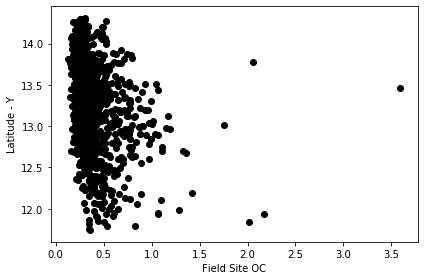

In [13]:
# build a regression an plot the data and the line of best fit 

#pull out train and test sets (80% train, 20% test)
train_x = X[:int(len(X)*.8)]
test_x = X[int(len(X)*.8):]
    
train_y = Y[:int(len(Y)*.8)]
test_y = Y[int(len(Y)*.8):]
    
# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(train_x, train_y)

# Make predictions using the testing set of x values
y_pred = regr.predict(test_x)
    
# The coefficients
print('Coefficients: \n', regr.coef_)
    
# The intercept
print('Intercept: \n', regr.intercept_)
    
# The mean squared error
print('Mean squared error: %.2f'
    % mean_squared_error(test_y, y_pred))
    
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
    % r2_score(test_y, y_pred))

# Plot outputs  
fig, ax = plt.subplots()
ax.scatter(X, Y,  color='black')
# ax.plot(test_x, y_pred, color='blue', linewidth=3)
# change these as neeeded! 
ax.set_xlabel('Field Site OC')
ax.set_ylabel('Latitude - Y')
        
# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
fig = plt.gcf()
plt.show()

In [8]:
KG_silt = xr.open_rasterio('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\Field_Data\\KG_silt_fval.tif')
KG_sand = xr.open_rasterio('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\Field_Data\\KG_sand_fval.tif')
KG_clay = xr.open_rasterio('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\Field_Data\\KG_clay_fval.tif')
field_avg_sand = xr.open_rasterio('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\Field_Data\\FSandAvgClip.tif')

HD_silt = xr.open_rasterio('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\Field_Data\\HD_silt_fval.tif')
HD_sand = xr.open_rasterio('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\Field_Data\\HD_sand_fval.tif')
HD_clay = xr.open_rasterio('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\Field_Data\\HD_clay_fval.tif')
HD_oc = xr.open_rasterio('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\Field_Data\\HD_oc_fval.tif')
HD_grav = xr.open_rasterio('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\Field_Data\\HD_grav_fval.tif')

SG_silt = xr.open_rasterio('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\Field_Data\\SG_silt_fval.tif')
SG_sand = xr.open_rasterio('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\Field_Data\\SG_sand_fval.tif')
SG_clay = xr.open_rasterio('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\Field_Data\\SG_clay_fval.tif')
SG_oc = xr.open_rasterio('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\Field_Data\\SG_oc_fval.tif')
SG_cf = xr.open_rasterio('C:\\Users\\Research\\Documents\\Tara_Fall_2019\\Field_Data\\SG_cf_fval.tif')

In [30]:
# Aggregate SoilGrids AWC values (12.5m) out to resolution of Soil Moisture data (.25 degrees ~27.75 km) by taking the mean
# Then regress awc values on soil moisture at the lower resolution level to see if there is a relationship
# such large mismatch in the resolution of these data sets was messing with the optimization of the regression 

# pull data out 
x_data = field_avg_sand
y_data = SG_sand

# pull values and flatten into np arrays 
x_arr = x_data.values.flatten()
y_arr = y_data.values.flatten()
nd_x = x_arr[0]
nd_y = y_arr[0]
index_x = np.argwhere(x_arr==nd_x)
index_y = np.argwhere(y_arr==nd_y)
X = np.delete(x_arr, index_x).reshape(-1, 1)
Y = np.delete(y_arr, index_x).reshape(-1, 1)

# X = x_arr[x_arr != x_arr[0]].reshape(-1, 1)
# Y = y_arr[y_arr != 128].reshape(-1, 1)
print ((nd_x in X), (nd_y in Y))


# # shift data by one so there are no zero values in the data 
# x_arr_t = x_arr + 1
# y_arr_t = y_arr + 1

# # create nan mask so cells with missing data from either dataset are omitted
# # WANT: only data cells where there is data in BOTH datasets
# nan_mask = (~isnan(x_arr_t) * ~isnan(y_arr_t)).astype(int)

# # multiply x and y values by mask to zero out cells where data is missing 
# # note that none of the original data values are zero to avoid deleting actual data 
# masked_x = nan_mask*x_arr_t
# masked_y = nan_mask*y_arr_t

# # drop data entries where one or both datasets have zero values or nan values
# no_zero_x = masked_x[ masked_x != 0]
# no_nan_x = no_zero_x[~np.isnan(no_zero_x)]
# # go back and shift data back to original postion - divide by 100 because initial data was multiplied by 100 to preserve decimal points 
# X_1 = (no_nan_x - 1).reshape(-1, 1)
    
# no_zero_y = masked_y[ masked_y != 0]
# no_nan_y = no_zero_y[~np.isnan(no_zero_y)]
# Y_1 = (no_nan_y - 1).reshape(-1, 1)

False False


Coefficients: 
 [[0.16886312]]
Intercept: 
 [64.911575]
Mean squared error: 84.02
Coefficient of determination: -1.32


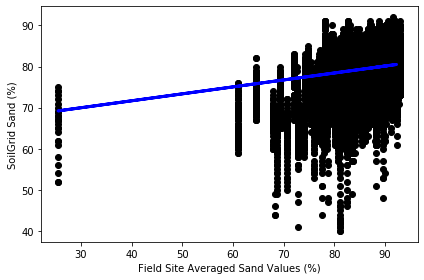

In [31]:
# build a regression an plot the data and the line of best fit 

#pull out train and test sets (80% train, 20% test)
train_x = X[:int(len(X)*.8)]
test_x = X[int(len(X)*.8):]
    
train_y = Y[:int(len(Y)*.8)]
test_y = Y[int(len(Y)*.8):]
    
# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(train_x, train_y)

# Make predictions using the testing set of x values
y_pred = regr.predict(test_x)
    
# The coefficients
print('Coefficients: \n', regr.coef_)
    
# The intercept
print('Intercept: \n', regr.intercept_)
    
# The mean squared error
print('Mean squared error: %.2f'
    % mean_squared_error(test_y, y_pred))
    
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
    % r2_score(test_y, y_pred))

# Plot outputs  
fig, ax = plt.subplots()
ax.scatter(X, Y,  color='black')
ax.plot(test_x, y_pred, color='blue', linewidth=3)
# change these as neeeded! 
ax.set_ylabel('SoilGrid Sand (%)')
ax.set_xlabel('Field Site Averaged Sand Values (%)')
        
# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
fig = plt.gcf()
plt.show()